## Predicting uncertainty with (deep) neural networks

### Selected Distribution - Standard Exponential

Hypothesis: 
    - Is it the predicted variance error distribution equals to the real variance error distirbution?
    - Do the parameters values of the distribution change with heteroscedasticity?

**NOTE**: This notebook has been adapted from the original version : https://github.com/sthorn/deep-learning-explorations/blob/master/predicting-uncertainty.ipynb*

### Imports 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import statistics as stat

%matplotlib inline

### Generate some random data

In [2]:
# Generate some linearly related data
np.random.seed(2019)

n_samples = 10000
x = np.random.standard_exponential(n_samples)

sin_ = 0.4 * np.sin(x*4*np.pi)
eps = np.random.standard_exponential(size=n_samples) * sin_ # noise
y_1 = 2*x + 1 
y = y_1 + eps # linear data with noise

### Describe the generated data

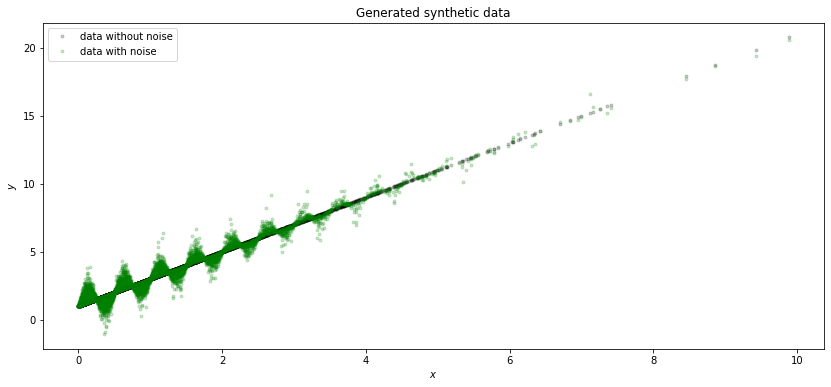

In [3]:
# Plot the data
plt.figure(figsize=(14,6))
plt.title('Generated synthetic data')

# plot data (with and without noise addition) 
plt.plot(x, y_1, '.', alpha=0.2, color='black' ) 
plt.plot(x, y, '.', alpha=0.2, color='green' ) 

plt.legend([r'data without noise',r'data with noise', r'$\mu$', r'$\pm\sigma$'])
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

### Prepare data for training

In [4]:
# Add in column of dummy zeros to represent sigma 
sigma = np.zeros(y.size)
y = np.stack([y, sigma], axis=1)

In [5]:
# Reshape x for PyTorch
#x = x.reshape(10000, 1)
x = x.reshape(x.size, 1)

In [6]:
# Split into training and validation sets
n_validation = 500
x_val, x = x[:n_validation], x[n_validation:]
y_val, y = y[:n_validation], y[n_validation:]

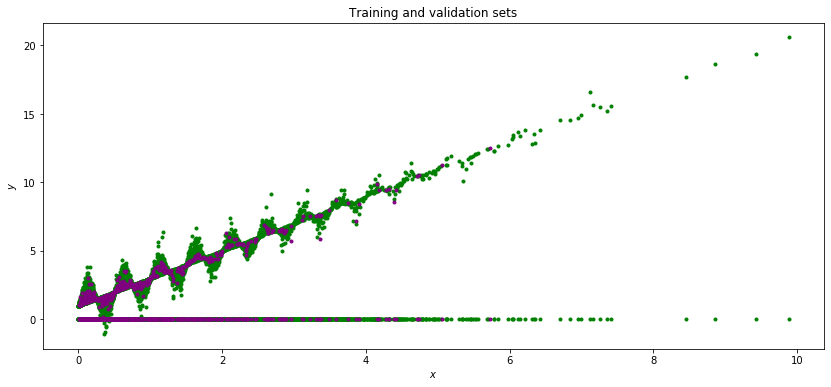

In [7]:
# Plot the data
plt.figure(figsize=(14,6))
plt.title('Training and validation sets')
plt.plot(x, y, '.', color= 'green')
plt.plot(x_val, y_val, '.', color='purple')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

In [8]:
# Convert x and y to PyTorch Variables on the GPU
dtype = torch.cuda.FloatTensor
x_t = Variable(torch.from_numpy(x).type(dtype))
y_t = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)

In [9]:
# Check shape ok for PyTorch - x should be (n x 1), y (n x 2)
x_t.shape, y_t.shape

(torch.Size([9500, 1]), torch.Size([9500, 2]))

## Experiment 

### Create a simple network 

In [10]:
# Create a simple two-layer network with one input (x) and two outputs (y, sigma)
n_inputs = 1
n_outputs = 2
n_hidden = 1000
model_1 = torch.nn.Sequential(torch.nn.Linear(n_inputs, n_hidden),
                            torch.nn.ReLU(),
                            torch.nn.Linear(n_hidden, n_outputs)
                           ).cuda()

In [11]:
# Adam optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)

### Custom loss function
This is where the magic happens.

In [12]:
def loss_variance_error(input, target):
    
    # Estimate target value for variance (sigma^2) with (y_pred - y)**2
    #
    #    actual y        is target[:,0]
    # predicted y        is input[:,0]
    #    actual variance is target[:,1] - estimated here
    # predicted variance is input[:,0]
    
    # Use 'requires_grad == False' to prevent PyTorch from trying to differentiate 'target'
    target[:,1] = Variable((input[:,0].data - target[:,0].data)**2, 
                           requires_grad=False)  
    # Return MSE loss 
    return F.mse_loss(input, target)

### Training loop 
We train this simple model with batch size equal to the whole dataset.

In [13]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model_1(x_t)
    
    # Calculate loss
    loss = loss_variance_error(y_pred, y_t)
    if i%500 == 0: print(f'epoch: {i:4} loss: {loss.data.item():.3}',)

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

epoch:    0 loss: 3.78e+02
epoch:  500 loss: 0.218
epoch: 1000 loss: 0.173
epoch: 1500 loss: 0.164
epoch: 2000 loss: 0.158
epoch: 2500 loss: 0.154
epoch: 3000 loss: 0.149
epoch: 3500 loss: 0.145
epoch: 4000 loss: 0.141
epoch: 4500 loss: 0.137
epoch: 5000 loss: 0.133
epoch: 5500 loss: 0.13
epoch: 6000 loss: 0.127
epoch: 6500 loss: 0.124
epoch: 7000 loss: 0.122
epoch: 7500 loss: 0.119
epoch: 8000 loss: 0.117
epoch: 8500 loss: 0.114
epoch: 9000 loss: 0.112
epoch: 9500 loss: 0.109


### Get predictions for validation set 

In [39]:
# Get predicted y and sigma for validation set
x_val_t = Variable(torch.from_numpy(x_val).type(dtype)) 
pred_1 = model_1(x_val_t)

# prediction of the response variables
y_pred_1 = pred_1[:,0].cpu().data
sigma_pred_1 = pred_1[:,1].cpu().data

### Plot results

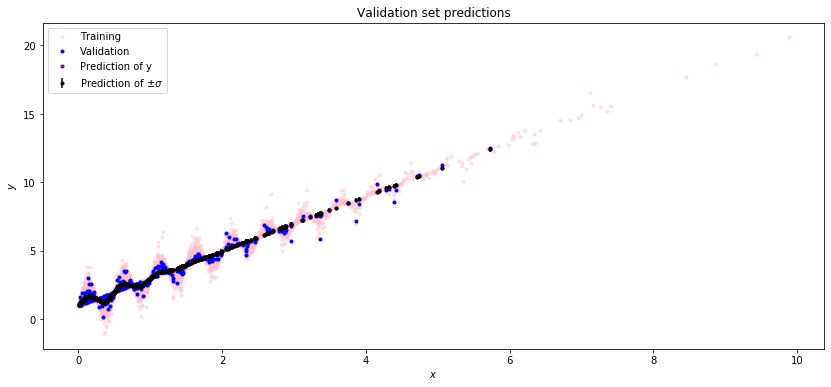

In [40]:
# Plot predictions and their errors
fig, ax1 = plt.subplots(figsize=(14,6))

ax1.plot(x, y[:,0], '.', alpha=0.4, color='pink')
ax1.plot(x_val, y_val[:,0], '.', color='blue')
ax1.plot(x_val, y_pred_1, '.', color='purple')
ax1.errorbar(x_val, y_pred_1, yerr=sigma_pred_1, fmt='.k');

ax1.set_xlabel(r'$x$');
ax1.set_ylabel(r'$y$');
ax1.set_title('Validation set predictions');
ax1.legend([r'Training', r'Validation', r'Prediction of y','Prediction of $\pm \sigma$'], loc='upper left', );

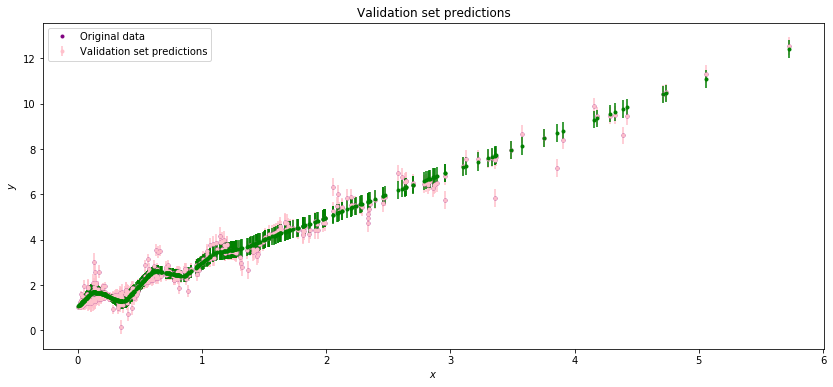

In [41]:
# Plot predictions and their errors
fig, ax1 = plt.subplots(figsize=(14,6))
ax1.plot(x_val, y_val[:,0], '.', color='purple')
ax1.errorbar(x_val, y_val[:,0], yerr=sigma_pred_1.sqrt() , color='pink', fmt='.'); 
ax1.errorbar(x_val, y_pred_1, yerr=sigma_pred_1.sqrt() , color='green', fmt='.'); 

# One standard-deviation envelope
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.title('Validation set predictions');
plt.legend([r'Original data','Validation set predictions'], loc='upper left', );

### Is it the predicted variance error distribution equals to the real variance error distirbution?

#### Predicted variance error distribution

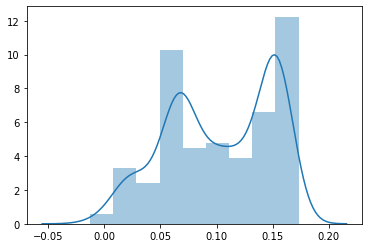

In [17]:
import seaborn as sns
sns.distplot(sigma_pred_1)

#### Generated error distribution

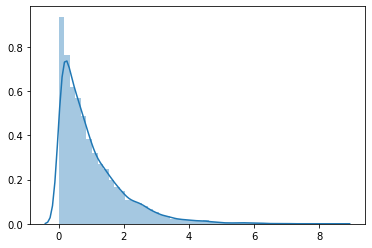

In [18]:
sns.distplot(np.random.standard_exponential(size=n_samples))

#### Predicted y response variable distribution

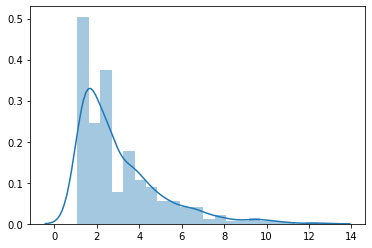

In [19]:
sns.distplot(y_pred_1)

#### Real y distribution (validation)

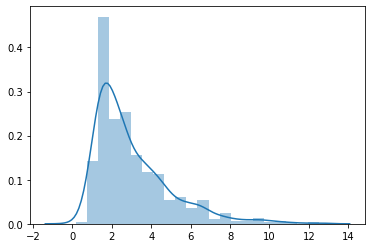

In [20]:
sns.distplot(y_val[:,0])

#### Real y distribution (training)

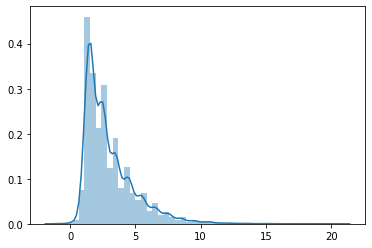

In [21]:
sns.distplot(y[:,0])

#### Real variance error distribution (validation)

In [22]:
real_sigma = (y_pred_1.numpy()- y_val[:,0])**2

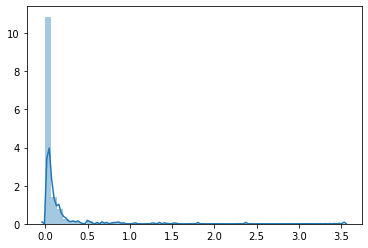

In [23]:
sns.distplot(real_sigma)

#### Real variance error distribution (training)

In [24]:
real_sigma_train = (y_pred_1.numpy()- y[:500,0])**2

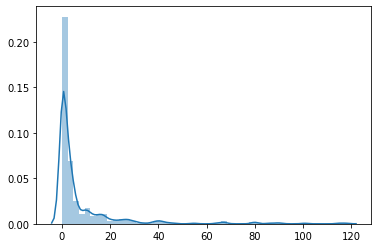

In [25]:
sns.distplot(real_sigma_train)

#### Plot the real variance error 

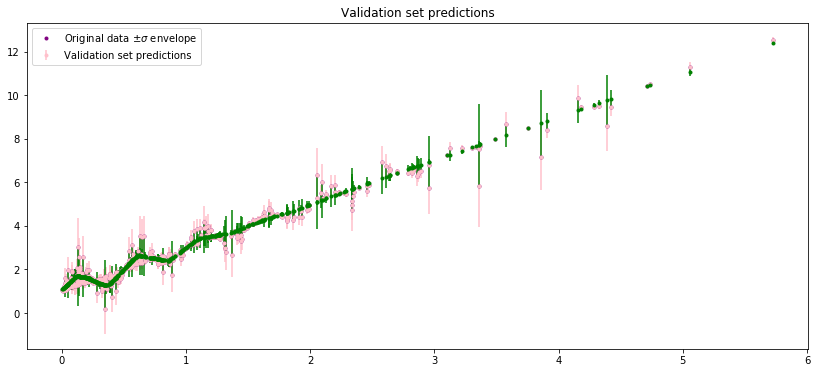

In [26]:
import math
# Plot predictions and their errors
fig, ax1 = plt.subplots(figsize=(14,6))

ax1.plot(x_val, y_val[:,0], '.', color='purple')
plt.errorbar(x_val, y_val[:,0], yerr=np.sqrt(real_sigma) , color='pink', fmt='.'); 
ax1.errorbar(x_val, y_pred_1, yerr=np.sqrt(real_sigma) , color='green', fmt='.'); 

# One standard-deviation envelope

plt.title('Validation set predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Validation set predictions'], loc='upper left');

### Are the two (real and predicted error variance) distributions the same?

#### Statistical tests to affirm the assumption extraced from plots 

In [27]:
from scipy import stats

#### Normality check with p-p plot and saphiro test

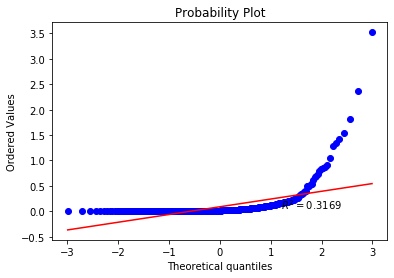

In [28]:
stats.probplot(real_sigma, fit=True, rvalue=True, plot=plt);

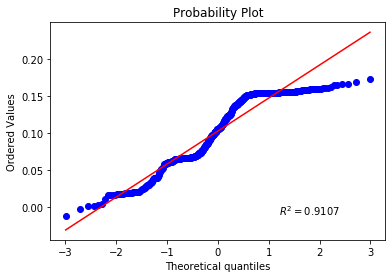

In [29]:
stats.probplot(sigma_pred_1, fit=True, rvalue=True, plot=plt);

In [30]:
stats.shapiro(sigma_pred_1)

(0.9083493947982788, 8.497019613059884e-17)

Comparing the two distributions with Kolmogorov-Smirnov

In [31]:
stats.ks_2samp(sigma_pred_1, real_sigma)

Ks_2sampResult(statistic=0.598, pvalue=1.9488038001756452e-83)

We can reject the null hypothesis: the two distribution are not identical

In [32]:
from utilities import validation_metrics

Global model performance: 

- R2 y_hat: 0.9759053672859788 
- RMSE y_hat: 0.08869453344629898 
- RMSE sigma_hat: 0.06373514690125635 

Extreme values performance:
 
- Upper bound - 19 Y pts  +sigma 0.25: 

R2 y_hat: 0.03247513462552031
RMSE y_hat: 1.937563709597055
MAE sigma_hat : 1.2673021711448418
-
 Lower bound - 18 Y pts -sigma 0.25: 

R2 y_hat: -0.15870896713444885
RMSE y_hat: 1.9285036334706807
MAE sigma_hat: 1.2657997762743276
-
 In bound - 463 Y pts in [+sigma 0.25,-sigma 0.25]: 

R2 y_hat: 0.9017323977801243
RMSE y_hat: 0.2779896103122079
MAE sigma_hat: 1.2158058724240737


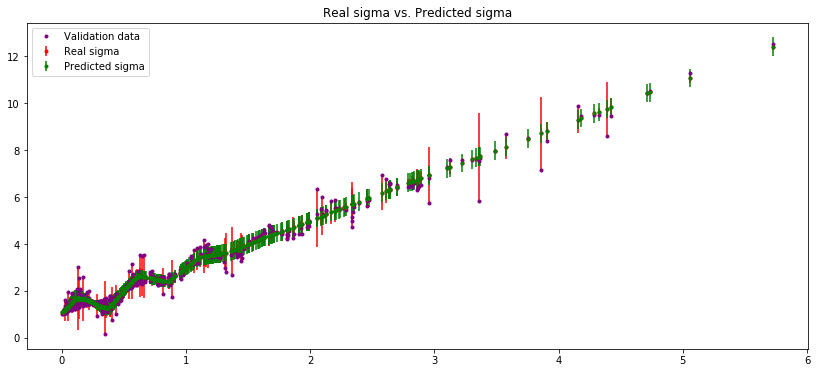

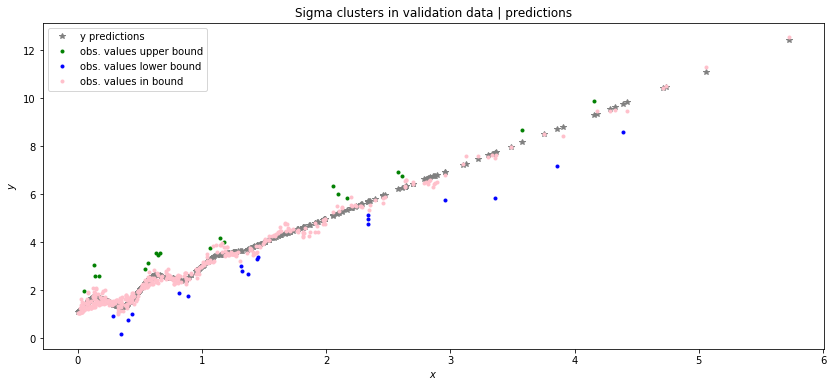

In [33]:
validation_metrics.overall_model_performance(x_val[:,0], y_val[:,0], y_pred_1, sigma_pred_1, std_factor=1/4, extreme_values_performance=True, display_plots=True)

#### Evaluating the results with evaluation_metrics library

--------------------------------- Distribution Tests --------------------------------------------

 ----> H0: Test Normal Distribution 
 - Test de Shapiro-Wilks
Negation - p_value = 0.0 Normal distribution: - x_val
Negation - p_value = 0.0 Normal distribution: - y_val
Negation - p_value = 0.0 Normal distribution: - y_hat
Negation - p_value = 0.0 Normal distribution: - sigma_real
Negation - p_value = 0.0 Normal distribution: - sigma_hat

 ----> H0: The two (sigma_hat and sigma_real) distributions are identical 
- Test de Kolmogorov-Smirnov
Negation - p_value = 0.0 equivalence of distributions - sigma_hat - sigma_val

 ----> H0: The y_hat | sigma_hat keeps its source distirbution 
- Test de Chi-Square
Aceptance - p_value = 1.0 keeps its source distirbution: y_val - y_hat
Negation - p_value = 0.0 keeps its source distirbution: sigma_val - sigma_hat

--------------------------------- Homoscedasticity Tests --------------------------------------------
Build the sigma clusters in y validatio

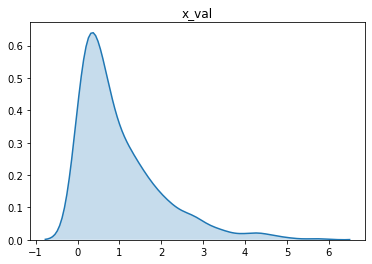

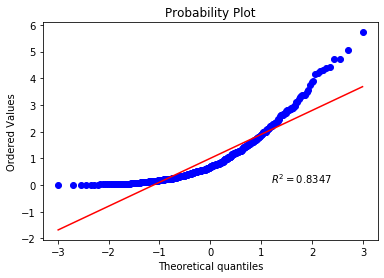

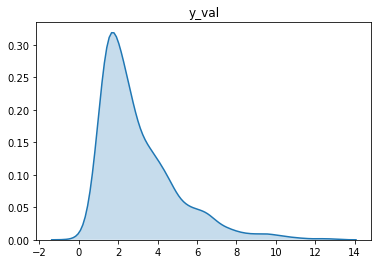

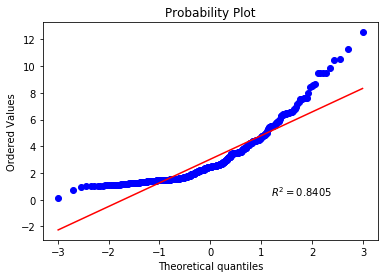

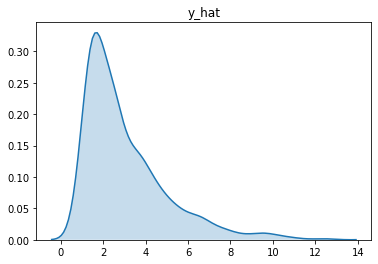

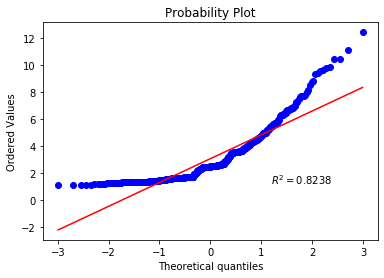

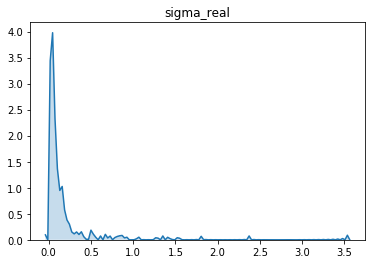

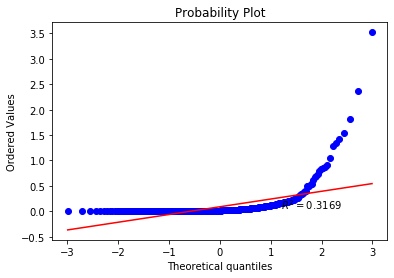

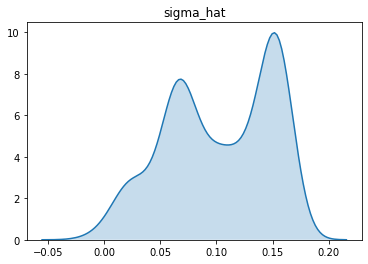

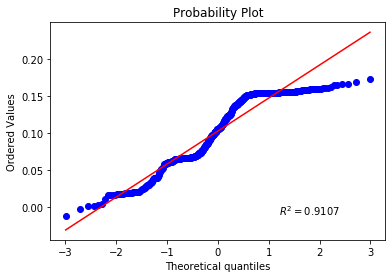

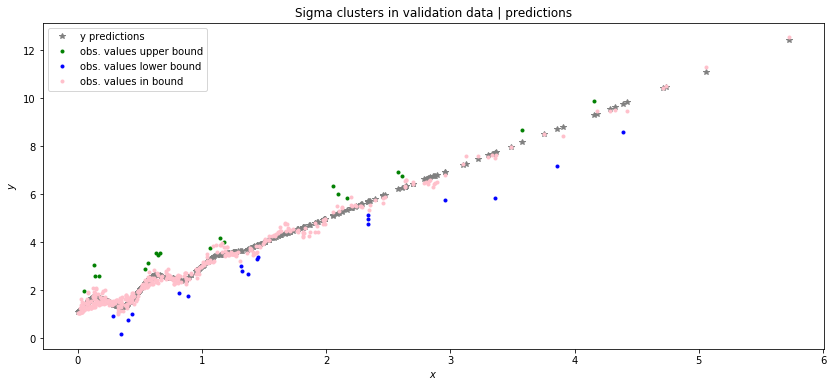

In [35]:
validation_metrics.tests_prior_beliefs(x_val[:,0], y_val[:,0], y_pred_1, sigma_pred_1)